In [1]:
# Run if working locally
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sqlite3
from sqlite3 import Error
import pickle
import os, sys
import config

config.root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, config.root_path)

from src.dataset.dataset import RawData
from src.dataset.wikisection_preprocessing import (
    tokenize,
    clean_sentence,
    preprocess_text_segmentation,
    format_data_for_db_insertion,
)
from src.dataset.utils import truncate_by_token
from db.dbv2 import Table, AugmentedTable, TrainTestTable
import pprint
from nltk.tokenize import word_tokenize

<IPython.core.display.Javascript object>

In [3]:
from src.bertkeywords.src.similarities import Embedding, Similarities
from src.bertkeywords.src.keywords import Keywords

<IPython.core.display.Javascript object>

In [7]:
pp = pprint.PrettyPrinter(indent=4)
similarities_lib = Similarities("bert-base-uncased")
keywords_lib = Keywords(similarities_lib.model, similarities_lib.tokenizer)
embedding_lib = Embedding(similarities_lib.model, similarities_lib.tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No sentence-transformers model found with name /Users/amitmaraj/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.

<IPython.core.display.Javascript object>

In [8]:
dataset_type = "city"
table = Table(dataset_type)
augmented_table = AugmentedTable(dataset_type)
train_test_table = TrainTestTable(dataset_type)

<IPython.core.display.Javascript object>

In [9]:
data = table.get_all()

text_data = [x[1] for x in data]
text_labels = [x[2] for x in data]

<IPython.core.display.Javascript object>

In [15]:
samples = 1

for row, label in zip(text_data[:samples], text_labels[:samples]):
    keywords = keywords_lib.get_batch_keywords_with_kb_embeddings(
        [row], use_mmr=True, mmr_diversity=0.8
    )
    print(label, keywords)

[('sebastiae', 0.5166, array([ 3.01045895e-01, -2.09571496e-01, -1.77952155e-01, -9.64389276e-03,
        2.99028307e-01, -2.60903448e-01,  3.92594904e-01,  2.35921592e-02,
       -4.11096066e-01, -2.92805821e-01,  1.79943398e-01, -8.86187851e-02,
       -8.77322536e-03,  3.67987156e-01, -2.37865839e-02,  4.72122669e-01,
       -4.34971780e-01, -5.28461598e-02,  3.81146461e-01, -2.67713517e-02,
        1.43611088e-01,  4.60083894e-02, -1.22421652e-01,  1.33494660e-01,
        1.43468365e-01,  2.78053973e-02, -4.62407976e-01, -9.67859402e-02,
       -4.37806129e-01, -7.99150988e-02,  1.59430742e-01, -4.90083806e-02,
       -4.07324106e-01,  2.58300930e-01, -3.12207371e-01,  3.70026119e-02,
        1.64071620e-01, -9.72165838e-02, -8.76910463e-02, -3.12458366e-01,
       -1.49611622e-01, -4.70615029e-01,  2.62594312e-01, -2.75971264e-01,
       -3.94830331e-02, -3.78335975e-02,  1.03248030e-01, -2.78402925e-01,
       -2.59609729e-01, -4.30508144e-02, -2.71956831e-01, -1.37124257e-02,
  

TypeError: 'float' object is not subscriptable

<IPython.core.display.Javascript object>

## Universal Sentence Encoder

In [8]:
# https://huggingface.co/Dimitre/universal-sentence-encoder

<IPython.core.display.Javascript object>

In [9]:
# @title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  # @param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print("module %s loaded" % module_url)


def embed(input):
    return model(input)

2023-03-26 18:40:12.936581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


<IPython.core.display.Javascript object>

In [10]:
# @title Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be."
)
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

2023-03-26 18:40:13.722352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Message: Elephant
Embedding size: 512
Embedding: [0.008344453759491444, 0.00048083634465001523, 0.06595247238874435, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.0508086122572422, -0.016524318605661392, 0.01573779433965683, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.028332678601145744, -0.0558621771633625, -0.01294148899614811, ...]



<IPython.core.display.Javascript object>

In [11]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd"
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(messages_):
    print(messages_)
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

<IPython.core.display.Javascript object>

['I like my phone', 'My phone is not good.', 'Your cellphone looks great.', 'Will it snow tomorrow?', 'Recently a lot of hurricanes have hit the US', 'Global warming is real', 'An apple a day, keeps the doctors away', 'Eating strawberries is healthy', 'Is paleo better than keto?', 'How old are you?', 'what is your age?']


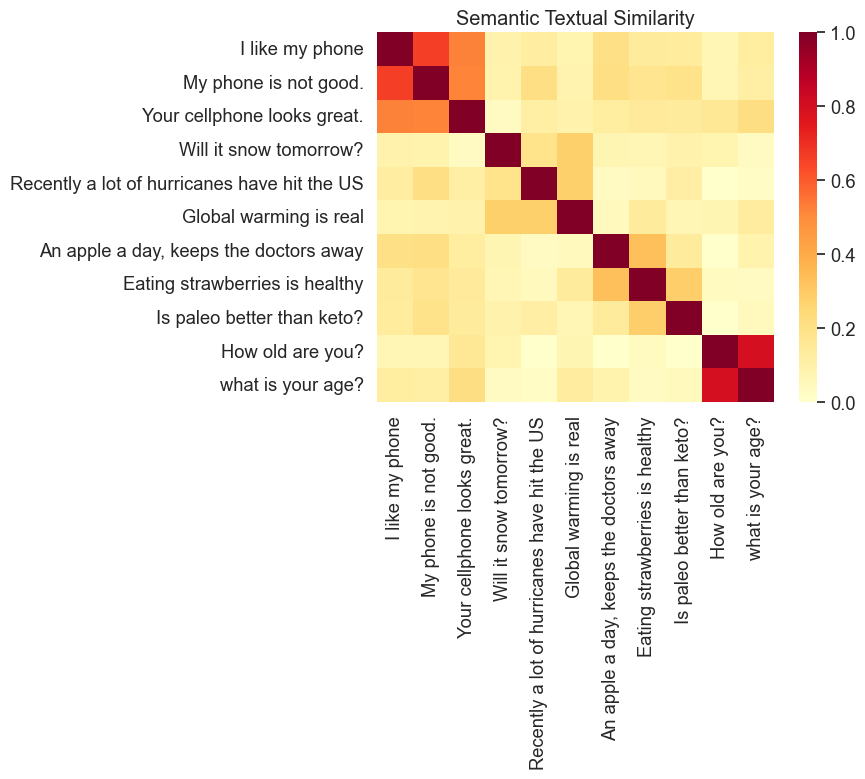

<IPython.core.display.Javascript object>

In [12]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",
    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",
    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",
    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

## USE with data

In [13]:
samples = 25
max_str_length = 30

<IPython.core.display.Javascript object>

In [14]:
samples = 25
max_str_length = 30

for i, (row, label) in enumerate(zip(text_data[:samples], text_labels[:samples])):
    if i == 0:
        pass
    else:
        prev_string = text_data[:samples][i - 1]
        truncated_string = (
            (row[:max_str_length] + "..") if len(row) > max_str_length else row
        )
        truncated_prev_string = (
            (prev_string[:max_str_length] + "..")
            if len(prev_string) > max_str_length
            else prev_string
        )

        prev_string_embedding = embed([prev_string])
        current_string_embedding = embed([row])
        similarity = cosine_similarity(prev_string_embedding, current_string_embedding)

        print(f"{label}, {similarity}, {truncated_prev_string} <> {truncated_string}")

0, [[0.27616197]], In spite of appearances, both .. <> The city is in the north of th..
0, [[0.3624012]], The city is in the north of th.. <> San Sebastián features an ocea..
0, [[0.17024839]], San Sebastián features an ocea.. <> The first evidence of human st..
0, [[0.323577]], The first evidence of human st.. <> San Sebastián is thought to ha..
0, [[0.5015319]], San Sebastián is thought to ha.. <> After a long period of silence..
0, [[0.75023353]], After a long period of silence.. <> The advent of the Modern Age b..
0, [[0.73843896]], The advent of the Modern Age b.. <> After the destructive events, ..
0, [[0.48289168]], After the destructive events, .. <> As a result of Donostia's spra..
0, [[0.61651945]], As a result of Donostia's spra.. <> The Parte Vieja (Old Town) is ..
0, [[0.56076825]], The Parte Vieja (Old Town) is .. <> This part stands at the west s..
0, [[0.50445306]], This part stands at the west s.. <> Or Old Amara, named after the ..
0, [[0.50057334]], Or Old Amara, nam

<IPython.core.display.Javascript object>

In [15]:
for i, (row, label) in enumerate(zip(text_data[:samples], text_labels[:samples])):
    if i == 0 or i == 1 or i == len(text_data[:samples]) - 1:
        pass
    else:
        prev_prev_string = text_data[:samples][i - 2]
        prev_string = text_data[:samples][i - 1]
        future_string = text_data[:samples][i + 1]
        truncated_string = (
            (row[:max_str_length] + "..") if len(row) > max_str_length else row
        )

        prev_string_embedding = embed([prev_prev_string + prev_string])
        current_string_embedding = embed([row + future_string])
        similarity = cosine_similarity(prev_string_embedding, current_string_embedding)

        prediction = 1 if similarity[0][0] < 0.5 else 0

        print(f"{label}, {prediction}, {similarity}, {truncated_string}")

0, 1, [[0.40923402]], San Sebastián features an ocea..
0, 1, [[0.39337394]], The first evidence of human st..
0, 1, [[0.37531263]], San Sebastián is thought to ha..
0, 1, [[0.49540144]], After a long period of silence..
0, 0, [[0.6928087]], The advent of the Modern Age b..
0, 0, [[0.7480403]], After the destructive events, ..
0, 0, [[0.612454]], As a result of Donostia's spra..
0, 0, [[0.663113]], The Parte Vieja (Old Town) is ..
0, 0, [[0.68255115]], This part stands at the west s..
0, 0, [[0.69103503]], Or Old Amara, named after the ..
0, 0, [[0.7254957]], This city expansion to the sou..
0, 0, [[0.6201457]], The district is built on the s..
0, 0, [[0.6306125]], One of the newest parts in the..
0, 0, [[0.61710954]], Egia, stemming from (H)Egia (B..
0, 0, [[0.6543241]], This part (meaning 'walnut tre..
0, 0, [[0.6973192]], Altza (Basque for alder tree) ..
0, 0, [[0.6545055]], Ibaeta stands on the former lo..
0, 0, [[0.5574168]], It lies by the Urumea at the s..
0, 0, [[0.6271712]], Ne

<IPython.core.display.Javascript object>

## Hybrid approach

- Take the regular cosine similarity as shown above.
- get all the important words using keybert for each sentence
    - get the cosine similarity from 1 important word to all the other important words in the next sentence
    - combine those similarities and come up with an overall score
    
Example:

Sentence 1 important words: 'committee', 'declarations', 'progress', 'powys', 'programme'
Sentence 2 important words: 'reports', 'healthcare', 'windscreen', 'ensuring', 'programme'

- committee -> reports (0.7)
- committee -> healthcare (0.2)
- committee -> windscreen (0.25)
- committee -> ensuring (0.4)
- committee -> programme (0.6)

- declarations -> reports (0.6)
- declarations -> healthcare (0.4)
- declarations -> windscreen (0.3)
- declarations -> ensuring (0.25)
- declarations -> programme (0.7)

...

In [16]:
samples = 25
max_tokens = 400  # want to keep this under 512

for i, (row, label) in enumerate(zip(text_data[:samples], text_labels[:samples])):
    if i == 0:
        pass
    else:
        prev_row = text_data[:samples][i - 1]
        row = truncate_by_token(row, max_tokens)
        prev_row = truncate_by_token(prev_row, max_tokens)
        truncated_string = (
            (row[:max_str_length] + "..") if len(row) > max_str_length else row
        )
        truncated_prev_string = (
            (prev_row[:max_str_length] + "..")
            if len(prev_row) > max_str_length
            else prev_row
        )

        keywords_current = keywords_lib.get_keywords(row)
        keywords_prev = keywords_lib.get_keywords(prev_row)

        word_comparisons = embedding_lib.compare_keywords(
            prev_row, row, keywords_prev, keywords_current
        )

        similarities = [comparison[2] for comparison in word_comparisons]
        avg_similarity = sum(similarities) / len(similarities)

        print(
            f"{label}, {avg_similarity}, {truncated_prev_string} <> {truncated_string}"
        )

0, tensor([0.2451]), In spite of appearances both t.. <> The city is in the north of th..
0, tensor([0.2880]), The city is in the north of th.. <> San Sebastián features an ocea..
0, tensor([0.2400]), San Sebastián features an ocea.. <> The first evidence of human st..
0, tensor([0.2602]), The first evidence of human st.. <> San Sebastián is thought to ha..
0, tensor([0.3303]), San Sebastián is thought to ha.. <> After long period of silence i..
0, tensor([0.3587]), After long period of silence i.. <> The advent of the Modern Age b..
0, tensor([0.2655]), The advent of the Modern Age b.. <> After the destructive events t..
0, tensor([0.2576]), After the destructive events t.. <> As result of Donostia sprawlin..
0, tensor([0.3098]), As result of Donostia sprawlin.. <> The Parte Vieja Old Town is th..
0, tensor([0.3583]), The Parte Vieja Old Town is th.. <> This part stands at the west s..
0, tensor([0.3722]), This part stands at the west s.. <> Or Old Amara named after the f..
0, tensor(

<IPython.core.display.Javascript object>

## Coherence testing

Based on a yard stick type approach, we want to make sure the beginning of the segment does not deviate as much from the end of the segment when it comes to what each sentence is talking about.

* As we walk through the segment, we want to collect important words along the way
* In order to accomplish that, we should check every sentence with the previous sentence to see if there are any similar terms. If so, add them to an array that we can use in the future to represent the segment in terms of important keywords

In [17]:
coherence_threshold = 0.7  # if two words are 70% similar in cosine similarity, add it to the coherence dict

samples = 25
max_tokens = 400  # want to keep this under 512


for i, (row, label) in enumerate(zip(text_data[:samples], text_labels[:samples])):
    # compare the current sentence to the previous one
    if i == 0:
        pass
    else:
        prev_row = text_data[:samples][i - 1]

        row = truncate_by_token(row, max_tokens)
        prev_row = truncate_by_token(prev_row, max_tokens)

        truncated_string = (
            (row[:max_str_length] + "..") if len(row) > max_str_length else row
        )
        truncated_prev_string = (
            (prev_row[:max_str_length] + "..")
            if len(prev_row) > max_str_length
            else prev_row
        )

        keywords_current = keywords_lib.get_keywords(row)
        keywords_prev = keywords_lib.get_keywords(prev_row)

        word_comparisons = embedding_lib.compare_keywords(
            prev_row, row, keywords_prev, keywords_current
        )

        similarities = [comparison[2] for comparison in word_comparisons]
        avg_similarity = sum(similarities) / len(similarities)

        print(
            f"{label}, {avg_similarity}, {truncated_prev_string} <> {truncated_string}"
        )

0, tensor([0.2451]), In spite of appearances both t.. <> The city is in the north of th..
0, tensor([0.2880]), The city is in the north of th.. <> San Sebastián features an ocea..
0, tensor([0.2400]), San Sebastián features an ocea.. <> The first evidence of human st..
0, tensor([0.2602]), The first evidence of human st.. <> San Sebastián is thought to ha..
0, tensor([0.3303]), San Sebastián is thought to ha.. <> After long period of silence i..
0, tensor([0.3587]), After long period of silence i.. <> The advent of the Modern Age b..
0, tensor([0.2655]), The advent of the Modern Age b.. <> After the destructive events t..
0, tensor([0.2576]), After the destructive events t.. <> As result of Donostia sprawlin..
0, tensor([0.3098]), As result of Donostia sprawlin.. <> The Parte Vieja Old Town is th..
0, tensor([0.3583]), The Parte Vieja Old Town is th.. <> This part stands at the west s..
0, tensor([0.3722]), This part stands at the west s.. <> Or Old Amara named after the f..
0, tensor(

<IPython.core.display.Javascript object>

In [47]:
import torch


def get_identical_coherent_words(sentence1, sentence2, coherence_threshold):
    kw_sentence2 = keywords_lib.get_keywords_with_embeddings(
        sentence2
    )  # "hello", "world", "fun"
    kw_sentence1 = keywords_lib.get_keywords_with_embeddings(
        sentence1
    )  # "fun", "circus", "bacon"

    coherent_words = []

    for word2 in kw_sentence2:
        for word1 in kw_sentence1:
            word1_text = word1[0]
            word2_text = word2[0]
            if word1_text == word2_text:
                # check similarity and add to coherent dictionary
                similarity = torch.cosine_similarity(
                    word1[2].reshape(1, -1), word2[2].reshape(1, -1)
                )

                if similarity[0] >= coherence_threshold:
                    coherent_words.append(word1)
                    coherent_words.append(word2)

    return coherent_words

<IPython.core.display.Javascript object>

In [ ]:

def get_similar_coherent_words(sentence1, sentence2, coherence_threshold):
    kw_sentence2 = keywords_lib.get_keywords_with_embeddings(
        sentence2
    )  # "hello", "world", "fun"
    kw_sentence1 = keywords_lib.get_keywords_with_embeddings(
        sentence1
    )  # "fun", "circus", "bacon"

    coherent_words = []

    for word2 in kw_sentence2:
        for word1 in kw_sentence1:
            word1_text = word1[0]
            word2_text = word2[0]
            # check similarity and add to coherent dictionary
            similarity = torch.cosine_similarity(
                word1[2].reshape(1, -1), word2[2].reshape(1, -1)
            )

            if similarity[0] >= coherence_threshold:
                coherent_words.append(word1)
                coherent_words.append(word2)

    return coherent_words

In [48]:
def build_coherence_map(
    segments: list[list[str]], max_words_per_step=2, coherence_threshold=0.4
):
    coherence_map = []
    prev_segment = None
    for segment in segments:
        if prev_segment is None:
            prev_segment = segment
            continue
        else:
            coherence_map.extend(
                get_coherent_words(prev_segment, segment, coherence_threshold)[
                    :max_words_per_step
                ]
            )
            prev_segment = segment

    return coherence_map

<IPython.core.display.Javascript object>

In [49]:
sent1 = "this is a sentence"
sent2 = "this is a similar sentence"
sent3 = "another sentence with some structure"
sent4 = "the structure is not that sound"
sent5 = "especially when it comes to architectural sound"

segments = [sent1, sent2, sent3, sent4, sent5]

<IPython.core.display.Javascript object>

In [50]:
get_coherent_words(sent1, sent2, 0.4)

[('sentence',
  0.7014,
  tensor([[-5.3195e-01, -4.4450e-01,  8.8038e-01, -3.2393e-01, -2.3992e-01,
           -4.7968e-01,  3.0541e-01,  9.0298e-01, -5.5524e-01,  1.2669e-01,
           -3.5169e-01, -1.0272e+00, -4.7082e-01,  8.5311e-01, -8.2825e-02,
            2.3607e-01,  3.4302e-01, -4.3738e-01,  3.5020e-01,  5.8092e-02,
           -3.4075e-01,  8.2440e-01, -6.4078e-01,  8.3465e-02,  5.1709e-01,
            2.3031e-01,  2.6988e-01,  4.4683e-03, -7.9288e-03,  4.3575e-01,
            1.2502e-02,  4.3752e-01, -1.2635e-01, -3.1304e-01, -2.5395e-01,
           -3.2005e-01,  3.9523e-01, -5.1550e-01, -4.2603e-01,  1.6890e-01,
           -2.0222e-01, -5.1452e-01,  4.9835e-01, -3.9038e-01, -5.5487e-01,
           -3.9609e-01, -2.0280e-01, -1.7891e-01,  4.6230e-02, -1.4034e-01,
           -5.9959e-01, -3.4453e-01,  3.5152e-01,  2.5620e-01, -4.1940e-01,
            3.8271e-01,  6.7446e-02, -9.4289e-01, -2.2985e-01, -2.4299e-01,
            6.2099e-01, -8.9386e-03,  8.1117e-02, -5.9510e-02,  

<IPython.core.display.Javascript object>

In [22]:
build_coherence_map(segments)

['sentence', 'this', 'sentence', 'structure', 'sound']

<IPython.core.display.Javascript object>